# Plot Something

In [1]:
%matplotlib inline
import cosima_cookbook as cc
from dask.distributed import Client
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import cmocean as cm

In [4]:
db = '/g/data/x77/amh157/anu-tub/diagnostics/anu-tub.db'
session=cc.database.create_session(db)

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37789,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://10.0.128.162:39393,Total threads: 4
Dashboard: /proxy/42077/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:36243,


# Simulations

|Run Name | Parameters | Notes| 
|---|---|---|
| 'anu-tub-control'| REGRIDDING_COORDINATE_MODE = “ZSTAR” | Original case |
| 'anu-tub-adapt'| REGRIDDING_COORDINATE_MODE = "ADAPTIVE" | First attempt at adaptive with standard parameters. Convective adjustment switched off. | 

# Spinup Diagnostics


In [3]:
experiments=['anu-tub-n2','anu-tub-n3']

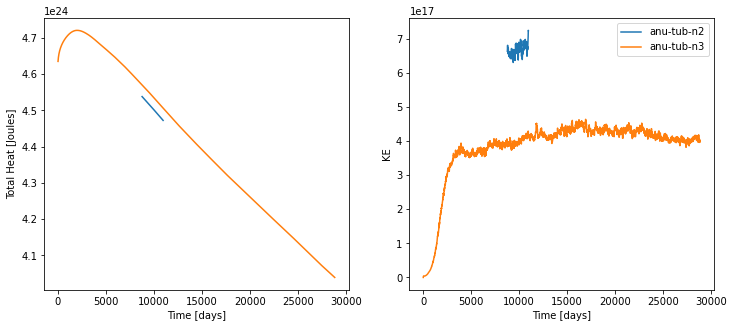

In [6]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

for experiment in experiments:
    variable = 'Heat'
    darray = cc.querying.getvar(experiment, variable, session,ncfile='ocean.stats.nc',decode_times=False)
    darray.coords['Time'] = darray.coords['Time']
    darray.plot(ax=ax[0],label=experiment)
    
    variable = 'KE'
    darray = cc.querying.getvar(experiment, variable, session,ncfile='ocean.stats.nc',decode_times=False)
    darray.coords['Time'] = darray.coords['Time']
    darray.sum('Layer').plot(ax=ax[1],label=experiment)
    
plt.legend()

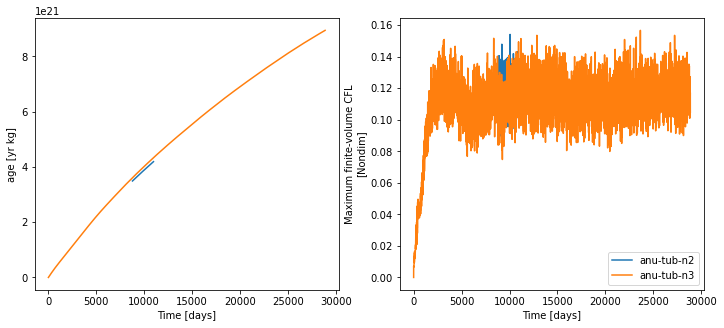

In [7]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

for experiment in experiments:
    variable = 'age'
    darray = cc.querying.getvar(experiment, variable, session,ncfile='ocean.stats.nc',decode_times=False)
    darray.coords['Time'] = darray.coords['Time']
    darray.plot(ax=ax[0],label=experiment)
    
    variable = 'max_CFL_trans'
    darray = cc.querying.getvar(experiment, variable, session,ncfile='ocean.stats.nc',decode_times=False)
    darray.coords['Time'] = darray.coords['Time']
    darray.plot(ax=ax[1],label=experiment)

    
plt.legend()

# Plot N-S transect after a number of days.

Text(0.5, 0, 'Latitude')

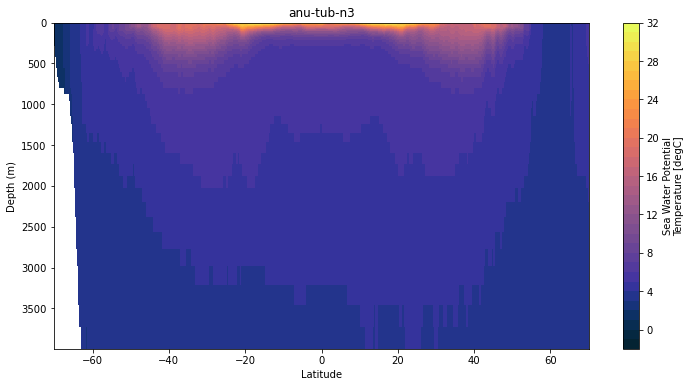

In [20]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
vlev = np.linspace(-2,32,35)
experiment='anu-tub-n3'
timeslice = -1
tarray = cc.querying.getvar(experiment, 'thetao', session)#,ncfile='prog.nc')
t1 = tarray.isel(time=-1).isel(xh=30).load()
t1.plot(levels=vlev,cmap=cm.cm.thermal)
ax.set_ylabel('Depth (m)')
ax.set_title(experiment)
plt.gca().invert_yaxis()
ax.set_xlabel('Latitude')


Text(0.5, 0, 'Latitude')

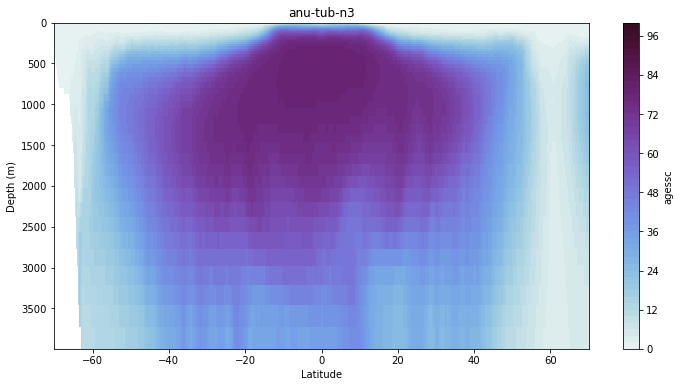

In [25]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
vlev = np.linspace(0,100,51)
experiment='anu-tub-n3'
timeslice = -1
tarray = cc.querying.getvar(experiment, 'agessc', session)#,ncfile='prog.nc')
t1 = tarray.isel(time=-1).mean('xh').load()
t1.plot(levels=vlev,cmap=cm.cm.dense)
ax.set_ylabel('Depth (m)')
ax.set_title(experiment)
plt.gca().invert_yaxis()
ax.set_xlabel('Latitude')

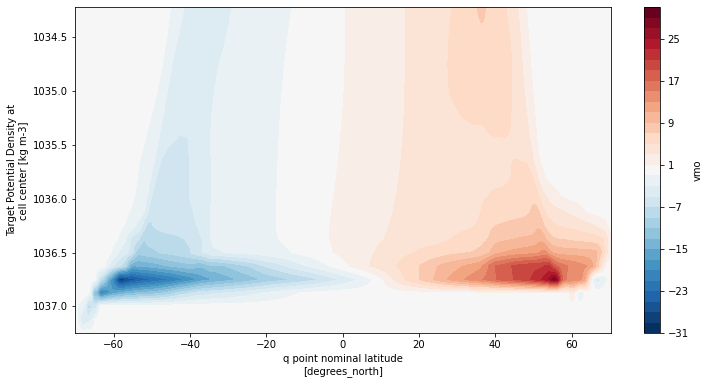

In [38]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
darray = cc.querying.getvar(experiment, 'vmo', session,start_time='0050-02-01')
moc = darray.sum('xh').mean('time').cumsum('rho2_l').sel(rho2_l=slice(1034,1037.3)).load()/1e9
#moc.coords['zl'] = np.linspace(1022,1029,75)
moc.plot.contourf(levels=np.linspace(-31,31,32),yincrease=False)

In [39]:
def plot_mercator(ax,X0,Y0):
    X,Y = np.meshgrid(X0,Y0)
    X_alt = (X - 20)*np.cos(Y*np.pi/180) + 20
    
    ax.set_frame_on(False)
    ax.plot(X_alt[:,0],Y[:,0],'k')
    ax.plot(X_alt[:,-1],Y[:,-1],'k')
    ax.plot([X_alt[-1,0], X_alt[-1,-1]],[69.8, 69.8],'k')
    ax.plot([X_alt[0,0], X_alt[0,-1]],[-70, -70],'k')
    ax.set_xlabel('Longitude')
    
    ax.set_ylim(ymin=-70,ymax=70)
    plt.setp(ax,'xticks',[10, 20, 30])
    return X_alt, Y

Text(0.5, 1.0, 'Barotropic Streamfunction')

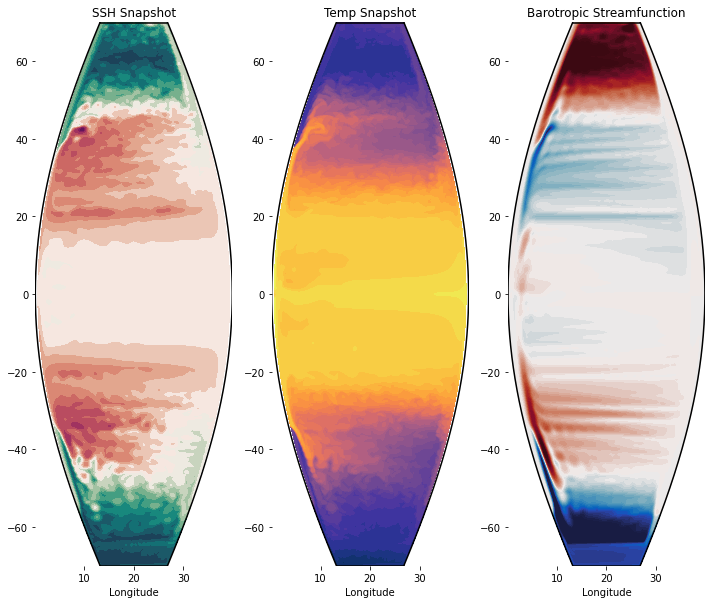

In [56]:
fig, ax = plt.subplots(1,3,figsize=(12,10))

#
darray = cc.querying.getvar(experiment, 'zos', session,start_time='0070-01-01',frequency='1 daily')
ssh_snap = darray.isel(time=-1)
X,Y = plot_mercator(ax[0],ssh_snap.coords['xh'],ssh_snap.coords['yh'])
p1=ax[0].contourf(X,Y,ssh_snap,levels=np.linspace(-1,1,21),extend='both',cmap=cm.cm.curl)
ax[0].set_title('SSH Snapshot')

#
darray = cc.querying.getvar(experiment, 'tos', session,start_time='0070-01-01')
temp_snap = darray.isel(time=-1)
X,Y = plot_mercator(ax[1],temp_snap.coords['xh'],temp_snap.coords['yh'])
p1=ax[1].contourf(X,Y,temp_snap,levels=np.linspace(-2,32,34),extend='both',cmap=cm.cm.thermal)
ax[1].set_title('Temp Snapshot')

#
darray = cc.querying.getvar(experiment, 'umo_2d', session,start_time='0070-02-01',frequency='1 monthly')
psi = darray.cumsum('yh').mean('time').load()/1e9
psi = psi - psi[-1,0]
X,Y = plot_mercator(ax[2],psi.coords['xq'],psi.coords['yh'])
p1=ax[2].contourf(X,Y,psi,levels=np.linspace(-50,50,51),extend='both',cmap=cm.cm.balance)
ax[2].set_title('Barotropic Streamfunction')